In [1]:
import numpy as np
import time

import PIL.Image as Image
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

# Get hub model

In [2]:
# MobileNetV2
classifier_model ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"

In [3]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_model, input_shape=IMAGE_SHAPE+(3,)) # + RGB
])

### test on a image

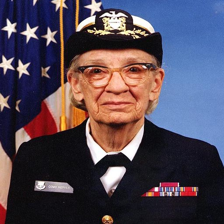

In [4]:
grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SHAPE)
grace_hopper

In [5]:
# normalize
grace_hopper = np.array(grace_hopper) / 255.0
grace_hopper.shape

(224, 224, 3)

In [6]:
# add a batch dimension, then predict
result = classifier.predict(grace_hopper[np.newaxis, ...])
result.shape

(1, 1001)

In [7]:
# get the most probable class
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

653

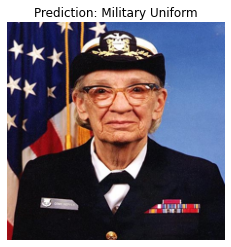

In [8]:
# get imagenet labels
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())
predicted_class_name = imagenet_labels[predicted_class]

plt.imshow(grace_hopper)
plt.axis('off')
_ = plt.title("Prediction: " + predicted_class_name.title())

# Transfer learning

### get data

In [9]:
data_root = tf.keras.utils.get_file(
  'flower_photos','https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
   untar=True)

In [10]:
# ImageDataGenerator to read data with rescaling
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory(str(data_root), target_size=IMAGE_SHAPE)

Found 3670 images belonging to 5 classes.


In [11]:
# read data is (image_batch, label_batch)
for image_batch, label_batch in image_data:
    print("Image batch shape: ", image_batch.shape)
    print("Label batch shape: ", label_batch.shape)
    break

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 5)


### use pretrained model without transfer learning

In [12]:
result_batch = classifier.predict(image_batch)
result_batch.shape

(32, 1001)

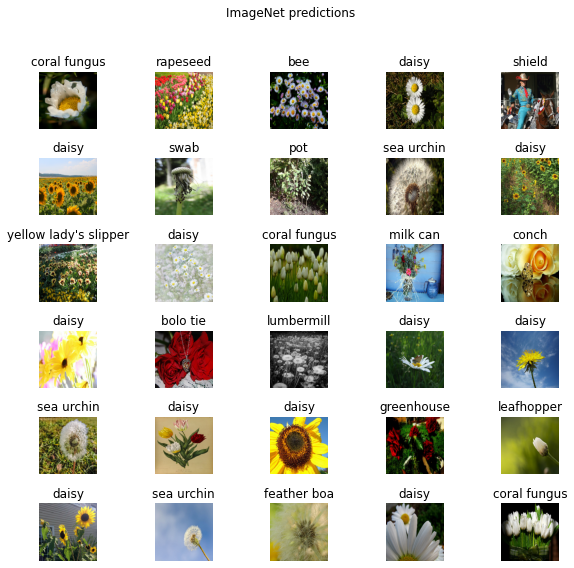

In [13]:
predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]

plt.figure(figsize=(10, 9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
    plt.subplot(6, 5, n+1)
    plt.imshow(image_batch[n])
    plt.title(predicted_class_names[n])
    plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

### remove original classification layer

In [14]:
# use the feature_vector model, which does not contain the classification layer
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor_layer = hub.KerasLayer(feature_extractor_model, input_shape=(224, 224, 3), trainable=False)  # freeze pretrained weights

In [15]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1280)


### use own classification layer

In [16]:
model = tf.keras.Sequential([
    feature_extractor_layer,
    tf.keras.layers.Dense(image_data.num_classes) # add a classification layer
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [17]:
predictions = model(image_batch)
predictions.shape

TensorShape([32, 5])

### train

In [19]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['acc']
)

In [20]:
# custom callback to log acc and loss of each batch individually, instead of epoch average
class CollectBatchStats(tf.keras.callbacks.Callback):
    def __init__(self):
        self.batch_losses = []
        self.batch_acc = []

    def on_train_batch_end(self, batch, logs=None):
        self.batch_losses.append(logs['loss'])
        self.batch_acc.append(logs['acc'])
        self.model.reset_metrics()

In [21]:
steps_per_epoch = np.ceil(image_data.samples / image_data.batch_size)

batch_stats_callback = CollectBatchStats()

history = model.fit(image_data, epochs=2, steps_per_epoch=steps_per_epoch, callbacks=[batch_stats_callback])

Epoch 1/2
115/115 [==============================] - 10s 83ms/step - loss: 0.3104 - acc: 0.9062
Epoch 2/2
115/115 [==============================] - 7s 63ms/step - loss: 0.4805 - acc: 0.8750


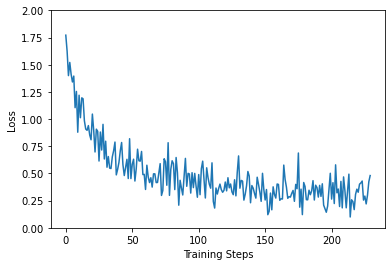

In [22]:
# plot it
plt.figure()
plt.ylabel('Loss')
plt.xlabel('Training Steps')
plt.ylim([0, 2])
plt.plot(batch_stats_callback.batch_losses)

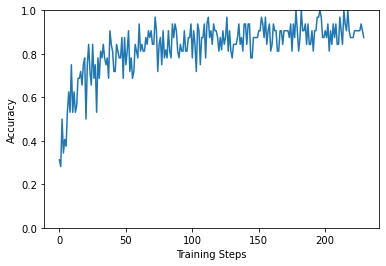

In [24]:
plt.figure()
plt.ylabel('Accuracy')
plt.xlabel('Training Steps')
plt.ylim([0, 1])
plt.plot(batch_stats_callback.batch_acc)

### predict

In [26]:
# sort the class names
class_names = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
class_names

array(['Daisy', 'Dandelion', 'Roses', 'Sunflowers', 'Tulips'],
      dtype='<U10')

In [27]:
# predict a batch and map indice to class names
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

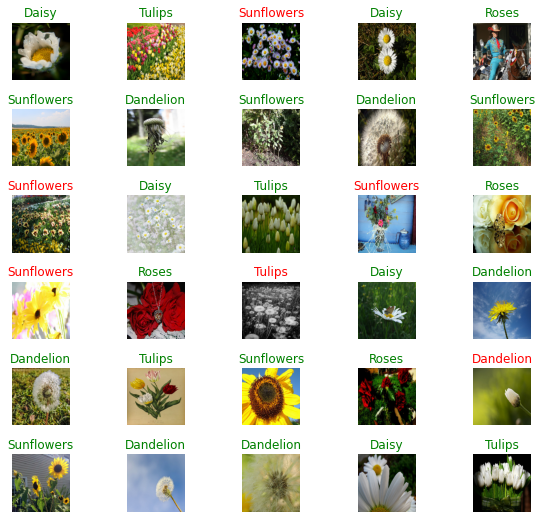

In [28]:
# plot predictions

label_id = np.argmax(label_batch, axis=-1)

plt.figure(figsize=(10, 9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
    plt.subplot(6, 5, n+1)
    plt.imshow(image_batch[n])
    color = 'green' if predicted_id[n] == label_id[n] else 'red'
    plt.title(predicted_label_batch[n].title(), color=color)
    plt.axis('off')

# Export model

In [29]:
t = time.time()

export_path = '/tmp/saved_models/{}'.format(int(t))
model.save(export_path)

export_path

INFO:tensorflow:Assets written to: /tmp/saved_models/1603833967\assets
INFO:tensorflow:Assets written to: /tmp/saved_models/1603833967\assets


'/tmp/saved_models/1603833967'

In [30]:
# reload model to check it is the same
reloaded = tf.keras.models.load_model(export_path)

result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)

abs(reloaded_result_batch - result_batch).max()

0.0